In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

In [2]:
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

In [3]:
df = pd.read_csv('/content/sample_data/potato_final.csv', index_col=0)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [4]:
df = df.drop(['Temp'],axis=1)
df = df.drop(['Oil'],axis=1)
df = df.drop(['Sup'],axis=1)
df = df.drop(['Avg_Price'], axis=1)

df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns =['DayOfWeek'], prefix='W', drop_first=True)

df.tail()

,Date,Rain,Wind,sobimul,nongmul,Price,Produced,W_1,W_2,W_3,W_4
2390,2022-09-26,0.0,1.7,2.5,8.7,415.0,549878,0,0,0,0
2391,2022-09-27,0.0,1.6,2.5,8.7,415.0,549878,1,0,0,0
2392,2022-09-28,0.0,1.8,2.5,8.7,415.0,549878,0,1,0,0
2393,2022-09-29,0.0,1.4,2.5,8.7,415.0,549878,0,0,1,0
2394,2022-09-30,0.0,1.6,2.5,8.7,415.0,549878,0,0,0,1


In [5]:
from sklearn.preprocessing import MinMaxScaler
input_indicator = df.loc[:,['Rain', 'Wind', 'sobimul', 'nongmul', 'Produced', 'W_1', 'W_2', 'W_3', 'W_4']]
target_indicator = df.loc[:,['Price']].values[:]

scaler_input = MinMaxScaler()
scaler_target = MinMaxScaler()
scaled_input_indicator = scaler_input.fit_transform(input_indicator)
scaled_target_indicator = scaler_target.fit_transform(target_indicator) # 가격 관련 지표에 스케일링

x = np.concatenate((scaled_target_indicator, scaled_input_indicator), axis=1)
y = x[:, [0]]

print(x)
print(y.shape)

[[0.23348694 0.         0.61403509 ... 1.         0.         0.        ]
 [0.31029186 0.         0.36842105 ... 0.         1.         0.        ]
 [0.33794163 0.         0.19298246 ... 0.         0.         1.        ]
 ...
 [0.3640553  0.         0.19298246 ... 1.         0.         0.        ]
 [0.3640553  0.         0.12280702 ... 0.         1.         0.        ]
 [0.3640553  0.         0.15789474 ... 0.         0.         1.        ]]
(2395, 1)


In [6]:
# 21일치의 input으로 8일치의 output을 생산(API 문제상 당일날 input은 활용 불가능할 것으로 예상됨)
# 추후 train, validation, train set를 6년, 2년, 2년으로 나눠볼까 생각중, 지금은 many_to_many 코드 구현을 목표로 구현하지 않음
seq_length = 7
predict_day = 7
dataX = [] 
dataY = [] 
for i in range(0, int(len(y) - seq_length - predict_day)):
    _x = x[i : i + seq_length]
    _y = y[i + predict_day : i + seq_length + predict_day] 
    dataX.append(_x) 
    dataY.append(_y) 
print(len(dataX))
print(len(dataY))

2381
2381


In [7]:
# Train Set 생성, 추후 Validation, Test도 여기에다가 추가 예상됨, 또한 21의 배수로 설정해야 batch에서 오류가 발생하지 않음
train_size = 1428
validation_size = 476
test_size = 476

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
validX = np.array(dataX[train_size:train_size+validation_size])
validY = np.array(dataY[train_size:train_size+validation_size])
testX = np.array(dataX[train_size+validation_size:train_size+validation_size+test_size])
testY = np.array(dataY[train_size+validation_size:train_size+validation_size+test_size])

print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(1428, 7, 10)
(1428, 7, 1)
(476, 7, 10)
(476, 7, 1)
(476, 7, 10)
(476, 7, 1)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Activation
from tensorflow import keras

In [9]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [11]:
input_columns = 10 # 데이터 셋의 '열' 개수 (dataX) / dataset's columns (dataX)

model = Sequential()
model.add(LSTM(16, batch_input_shape=(7, 7, input_columns), return_sequences=True, stateful=True, dropout=0.1))
model.add(LSTM(16, return_sequences=True, stateful=True, dropout=0.1))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (7, 7, 16)                1728      
                                                                 
 lstm_3 (LSTM)               (7, 7, 16)                2112      
                                                                 
 dense_1 (Dense)             (7, 7, 1)                 17        
                                                                 
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model-potato.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

In [13]:
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [14]:
custom_hist = CustomHistory()
custom_hist.init()

In [15]:
for epoch_idx in range(100):
  print('epochs:' + str(epoch_idx))
  hist = model.fit(trainX, trainY, validation_data=(validX, validY), epochs=1, batch_size=7, verbose=2, shuffle=False, callbacks=[checkpoint_cb, custom_hist, early_stopping_cb])
  model.reset_states()

epochs:0
204/204 - 9s - loss: 0.0366 - mae: 0.1492 - val_loss: 0.0156 - val_mae: 0.1106 - 9s/epoch - 44ms/step
epochs:1
204/204 - 1s - loss: 0.0207 - mae: 0.1071 - val_loss: 0.0123 - val_mae: 0.0986 - 1s/epoch - 5ms/step
epochs:2
204/204 - 1s - loss: 0.0165 - mae: 0.0922 - val_loss: 0.0122 - val_mae: 0.0969 - 981ms/epoch - 5ms/step
epochs:3
204/204 - 1s - loss: 0.0135 - mae: 0.0824 - val_loss: 0.0131 - val_mae: 0.1012 - 987ms/epoch - 5ms/step
epochs:4
204/204 - 1s - loss: 0.0117 - mae: 0.0750 - val_loss: 0.0083 - val_mae: 0.0777 - 981ms/epoch - 5ms/step
epochs:5
204/204 - 1s - loss: 0.0111 - mae: 0.0728 - val_loss: 0.0071 - val_mae: 0.0707 - 1s/epoch - 5ms/step
epochs:6
204/204 - 1s - loss: 0.0105 - mae: 0.0703 - val_loss: 0.0061 - val_mae: 0.0636 - 1s/epoch - 7ms/step
epochs:7
204/204 - 1s - loss: 0.0104 - mae: 0.0700 - val_loss: 0.0059 - val_mae: 0.0631 - 986ms/epoch - 5ms/step
epochs:8
204/204 - 1s - loss: 0.0098 - mae: 0.0670 - val_loss: 0.0050 - val_mae: 0.0548 - 989ms/epoch - 5ms

In [16]:
a = 7

In [17]:
model.evaluate(trainX, trainY, batch_size = a)

204/204 [==============================] - 1s 3ms/step - loss: 0.0054 - mae: 0.0550


[0.005436052568256855, 0.05495939776301384]

In [18]:
print(custom_hist.train_loss)

[0.036570679396390915, 0.020664559677243233, 0.016515716910362244, 0.013514367863535881, 0.011664079502224922, 0.011127548292279243, 0.010493607260286808, 0.010412094183266163, 0.009802632965147495, 0.008877035230398178, 0.008689403533935547, 0.008924368768930435, 0.008852754719555378, 0.0077794562093913555, 0.007587420288473368, 0.008837287314236164, 0.008236502297222614, 0.008121026679873466, 0.007836062461137772, 0.008159697987139225, 0.008090455085039139, 0.007072747219353914, 0.007504927925765514, 0.00664795795455575, 0.0076971049420535564, 0.008004250936210155, 0.008858215995132923, 0.007265687454491854, 0.007412579841911793, 0.007828767411410809, 0.007692472543567419, 0.007357527036219835, 0.00685444800183177, 0.00701984902843833, 0.007009785156697035, 0.006467082072049379, 0.006578176282346249, 0.006257823668420315, 0.006171469110995531, 0.006396794691681862, 0.007551155984401703, 0.008623295463621616, 0.006914383266121149, 0.006536263972520828, 0.006431918125599623, 0.00609802

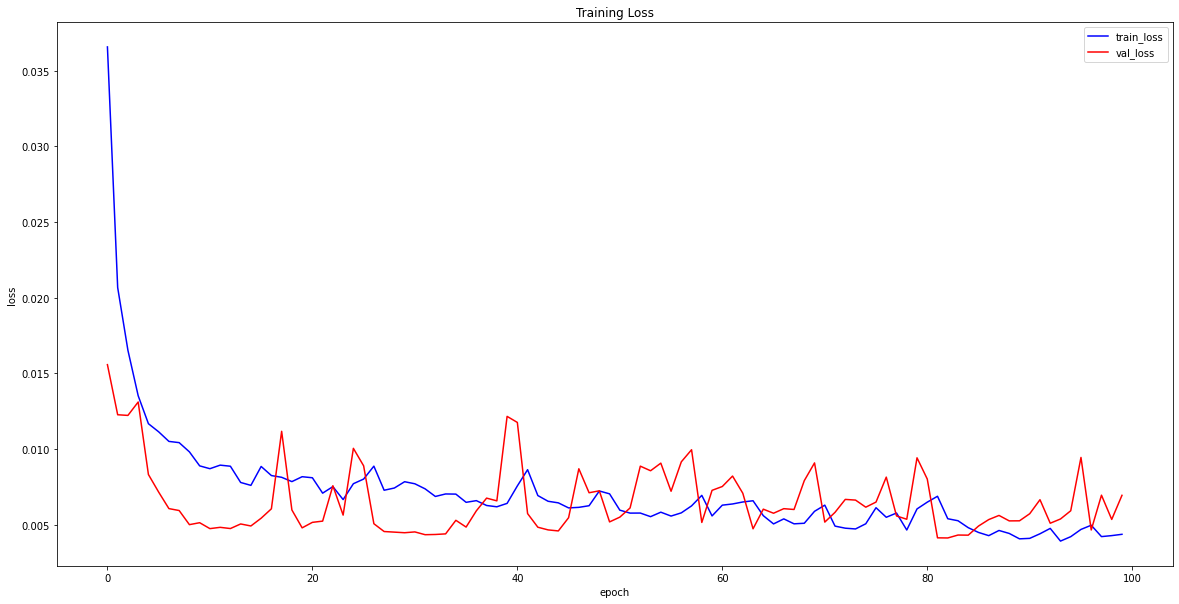

In [19]:
plt.figure(figsize=(20,10))
plt.plot(custom_hist.train_loss, color = 'blue', label = 'train_loss')
plt.plot(custom_hist.val_loss, color = 'red', label = 'val_loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
from keras.models import load_model
model = load_model('/content/best-model-potato.h5')

Train Data *평가*

In [21]:
model.evaluate(trainX, trainY, batch_size=a)

204/204 [==============================] - 1s 3ms/step - loss: 0.0041 - mae: 0.0466


[0.004079311620444059, 0.04663147032260895]

In [22]:
predicted_price_train = model.predict(trainX, batch_size=a, verbose=1) 

204/204 [==============================] - 1s 2ms/step


In [23]:
trainY_test = np.delete(trainY, np.s_[1:a], axis=1)
predicted_price_train_test = np.delete(predicted_price_train, np.s_[1:a], axis=1)

trainY_test = np.reshape(trainY_test, (1428, 1))
predicted_price_train_test = np.reshape(predicted_price_train_test, (1428, 1))
print(trainY_test.shape)
print(predicted_price_train_test.shape)

(1428, 1)
(1428, 1)


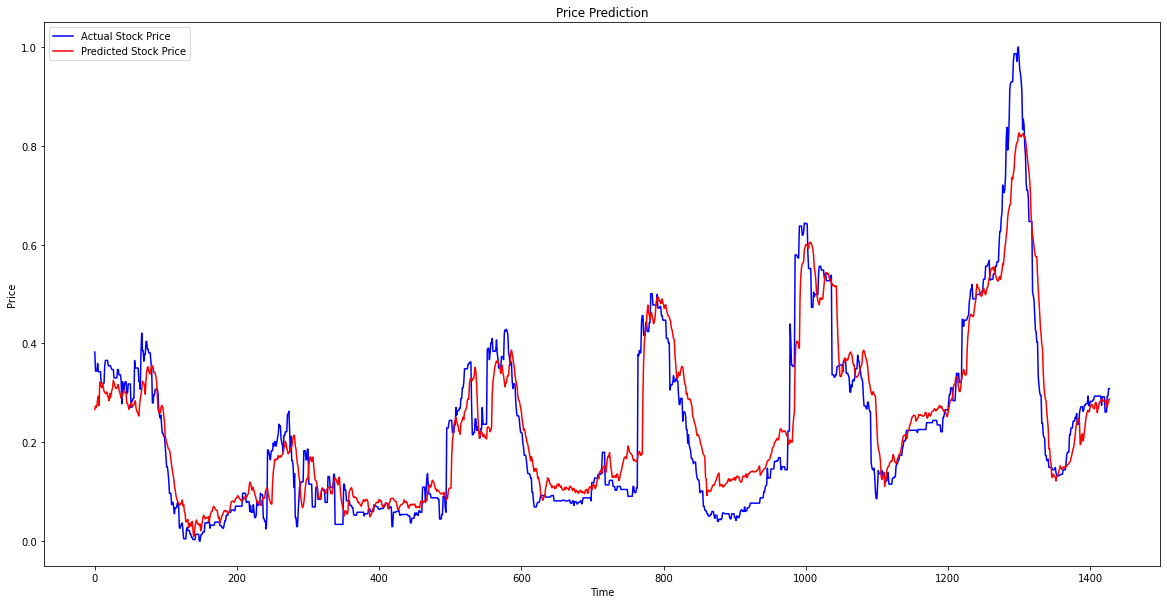

In [24]:
plt.figure(figsize=(20,10))
plt.plot(trainY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_train_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [26]:
predicted_price_train_test = np.reshape(predicted_price_train_test, (1428, ))
predicted_price_train_test = scaler_target.inverse_transform(predicted_price_train_test.reshape(-1,1))

print(predicted_price_train_test, predicted_price_train_test.shape)

trainY_test = scaler_target.inverse_transform(trainY_test.reshape(-1,1))

print(trainY_test, trainY_test.shape)

[[351.4175 ]
 [356.01892]
 [353.84958]
 ...
 [359.52176]
 [362.64188]
 [365.43942]] (1428, 1)
[[427.]
 [402.]
 [402.]
 ...
 [369.]
 [379.]
 [379.]] (1428, 1)


In [27]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(trainY_test, predicted_price_train_test) 
np.sqrt(MSE)

41.59462068266173

In [28]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(trainY_test, predicted_price_train_test)

30.395820671102914

Val Date 평가


In [29]:
model.evaluate(validX, validY, batch_size=a)

68/68 [==============================] - 0s 3ms/step - loss: 0.0041 - mae: 0.0500


[0.004108646418899298, 0.050012897700071335]

In [30]:
predicted_price_valid = model.predict(validX, batch_size=a, verbose=1) 

68/68 [==============================] - 0s 5ms/step


(476, 1)
(476, 1)


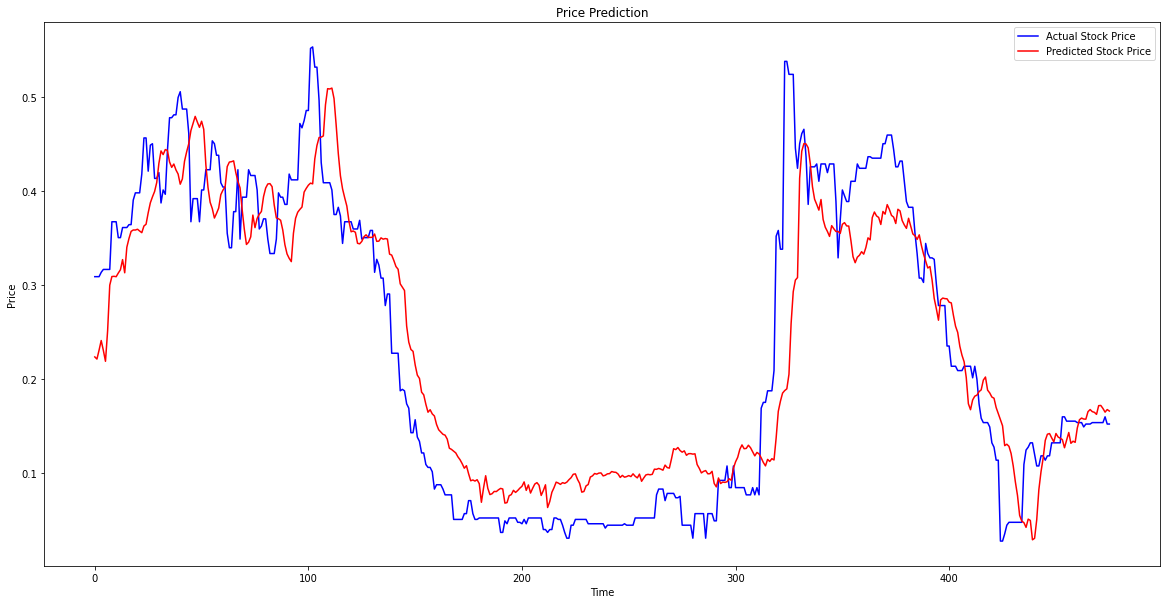

In [31]:
validY_test = np.delete(validY, np.s_[1:a], axis=1)
predicted_price_valid_test = np.delete(predicted_price_valid, np.s_[1:a], axis=1)

validY_test = np.reshape(validY_test, (476, 1))
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (476, 1))
print(validY_test.shape)
print(predicted_price_valid_test.shape)

plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [32]:
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (476, ))
predicted_price_valid_test = scaler_target.inverse_transform(predicted_price_valid_test.reshape(-1,1))

print(predicted_price_valid_test, predicted_price_valid_test.shape)

validY_test = scaler_target.inverse_transform(validY_test.reshape(-1,1))

print(validY_test, validY_test.shape)

[[323.45538]
 [321.96335]
 [328.15164]
 [334.806  ]
 [327.98367]
 [320.4269 ]
 [341.5485 ]
 [373.12103]
 [379.08633]
 [379.24078]
 [378.97754]
 [381.509  ]
 [383.78992]
 [390.79608]
 [381.67987]
 [399.37305]
 [405.4381 ]
 [410.34167]
 [411.29742]
 [411.27094]
 [411.82272]
 [410.58014]
 [409.44153]
 [414.04736]
 [415.28003]
 [423.20816]
 [430.1033 ]
 [434.24817]
 [437.96143]
 [444.21988]
 [457.34088]
 [466.00845]
 [463.4921 ]
 [466.95807]
 [466.3719 ]
 [458.37027]
 [454.66046]
 [456.92987]
 [452.8554 ]
 [450.02374]
 [442.98566]
 [446.64307]
 [458.82935]
 [465.36948]
 [471.05704]
 [480.11472]
 [484.9179 ]
 [489.92642]
 [486.00385]
 [482.33093]
 [486.56387]
 [481.0046 ]
 [456.33154]
 [440.72287]
 [430.47205]
 [426.13226]
 [419.569  ]
 [422.81012]
 [426.45685]
 [435.76428]
 [438.90497]
 [441.01508]
 [455.1762 ]
 [458.30655]
 [458.57065]
 [459.1327 ]
 [451.14304]
 [444.89944]
 [440.43857]
 [425.25464]
 [411.8024 ]
 [401.27798]
 [402.86276]
 [406.5437 ]
 [421.61066]
 [412.9198 ]
 [419.3066 ]

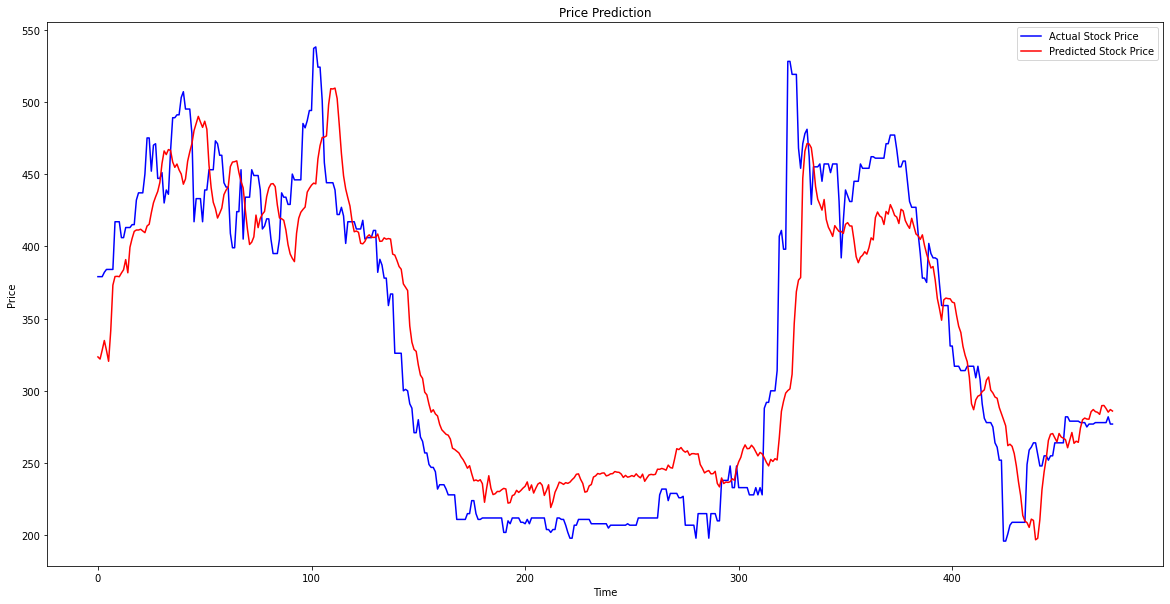

In [33]:
plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(validY_test, predicted_price_valid_test) 
np.sqrt(MSE)

42.05664389889643

In [35]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validY_test, predicted_price_valid_test)

32.922720067641315

Test Data 평가

In [36]:
model.evaluate(testX, testY, batch_size=a)

68/68 [==============================] - 0s 3ms/step - loss: 0.0080 - mae: 0.0649


[0.008036758750677109, 0.06485322117805481]

In [37]:
predicted_price_test = model.predict(testX, batch_size=a, verbose=1)

68/68 [==============================] - 0s 2ms/step


(476, 1)
(476, 1)


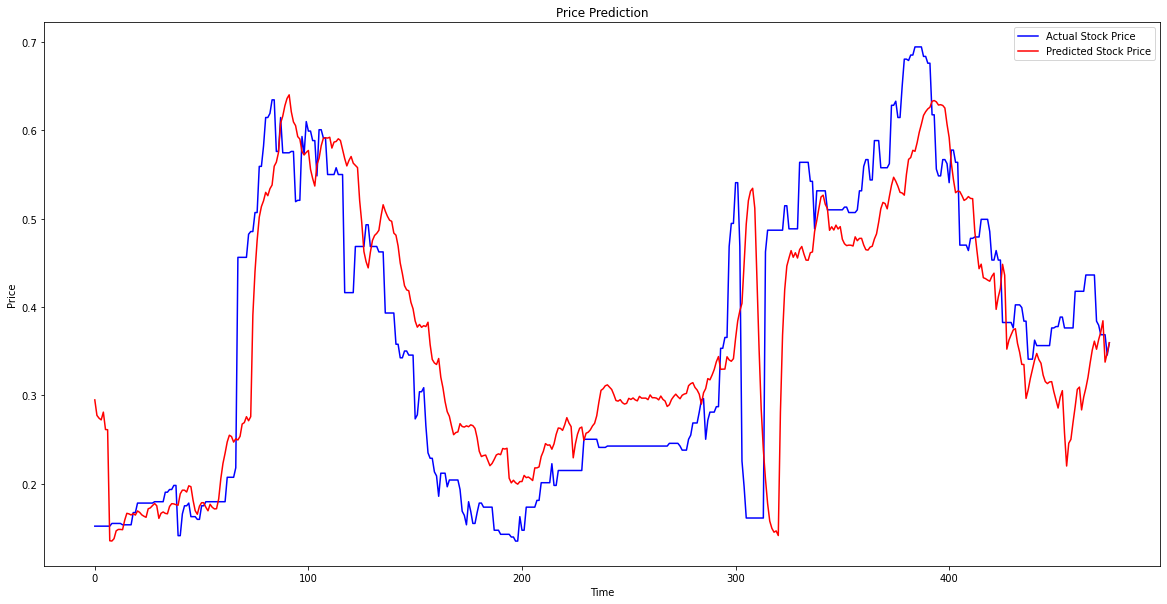

In [38]:
testY_test = np.delete(testY, np.s_[1:a], axis=1)
predicted_price_test_test = np.delete(predicted_price_test, np.s_[1:a], axis=1)

testY_test = np.reshape(testY_test, (476, 1))
predicted_price_test_test = np.reshape(predicted_price_test_test, (476, 1))
print(testY_test.shape)
print(predicted_price_test_test.shape)

plt.figure(figsize=(20,10))
plt.plot(testY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_test_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [39]:
predicted_price_test_test = np.reshape(predicted_price_test_test, (476, ))
predicted_price_test_test = scaler_target.inverse_transform(predicted_price_test_test.reshape(-1,1))

print(predicted_price_test_test, predicted_price_test_test.shape)

testY_test = scaler_target.inverse_transform(testY_test.reshape(-1,1))

print(testY_test, testY_test.shape)

[[369.99127]
 [358.57748]
 [356.5009 ]
 [355.28317]
 [360.99246]
 [348.18286]
 [348.03595]
 [266.26276]
 [266.03687]
 [267.7881 ]
 [273.54153]
 [274.5767 ]
 [274.5834 ]
 [274.39362]
 [281.3823 ]
 [286.46198]
 [286.04773]
 [285.2429 ]
 [286.24863]
 [285.1609 ]
 [288.20026]
 [287.1474 ]
 [285.32196]
 [284.31622]
 [283.5204 ]
 [289.79385]
 [290.46396]
 [292.15643]
 [293.6852 ]
 [292.04117]
 [282.72986]
 [286.48236]
 [287.44974]
 [286.42258]
 [286.0891 ]
 [291.51123]
 [293.56543]
 [293.39413]
 [292.8305 ]
 [292.41006]
 [300.81314]
 [303.5193 ]
 [303.50238]
 [302.14117]
 [306.7129 ]
 [306.07043]
 [296.11087]
 [288.4004 ]
 [285.7711 ]
 [291.7292 ]
 [294.28976]
 [294.22607]
 [290.8918 ]
 [288.32358]
 [293.08676]
 [290.86932]
 [289.70303]
 [289.83643]
 [297.03937]
 [311.95963]
 [323.1645 ]
 [330.74298]
 [339.05283]
 [343.97556]
 [343.00446]
 [338.92606]
 [341.36313]
 [340.4829 ]
 [343.12628]
 [352.2242 ]
 [353.2869 ]
 [357.6155 ]
 [354.6534 ]
 [357.66983]
 [432.3904 ]
 [464.44406]
 [487.44687]

In [40]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(testY_test, predicted_price_test_test) 
np.sqrt(MSE)

59.142476018696215

In [41]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(testY_test, predicted_price_test_test)

43.214509980017404

예측방법

In [42]:
minX1 = np.array(dataX[0:7])
minX2 = np.array(dataX[0:8])
minX3 = np.array(dataX[0:2380])
minX4 = np.array(dataX[0:train_size])

In [43]:
predicted_price_min1 = model.predict(minX1, batch_size=a, verbose=1)
predicted_price_min2 = model.predict(minX2, batch_size=a, verbose=1) 
predicted_price_min3 = model.predict(minX3, batch_size=a, verbose=1)
predicted_price_min4 = model.predict(minX4, batch_size=a, verbose=1) 

204/204 [==============================] - 1s 3ms/step


In [44]:
predicted_price_min1[0]

array([[0.31568873],
       [0.2930255 ],
       [0.28030497],
       [0.27462092],
       [0.28439492],
       [0.29099447],
       [0.2932449 ]], dtype=float32)

In [45]:
predicted_price_min2[0]

array([[0.26706427],
       [0.26876223],
       [0.27201018],
       [0.2757707 ],
       [0.29045895],
       [0.29825616],
       [0.3006701 ]], dtype=float32)

In [46]:
predicted_price_min3[0]

array([[0.27270868],
       [0.27261403],
       [0.27523005],
       [0.2780184 ],
       [0.29185596],
       [0.29892677],
       [0.3009637 ]], dtype=float32)

In [47]:
scaler_target.inverse_transform(predicted_price_min4[0].reshape(-1,1))

array([[383.51337],
       [368.7596 ],
       [360.47855],
       [356.7782 ],
       [363.1411 ],
       [367.4374 ],
       [368.90244]], dtype=float32)